In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

import scipy.stats as st
import statsmodels.api as sm

style.use('ggplot') or plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# 1. Load data

In [2]:
table_C = pd.read_csv("C_by_instance.csv")
table_C

Explotacion  Ejercicio   Hours  C_UR_10_P  C_UR_20_P  C_UR_30_P  \
0           55284       2014  2000.0          2          0          0   
1           55284       2015  2000.0          2          0          0   
2           55290       2014  2000.0          1          0          0   
3           55290       2015  2000.0          1          0          0   
4           55290       2016  2000.0          1          0          0   
...           ...        ...     ...        ...        ...        ...   
1757        92886       2018   635.0          1          0          0   
1758        92887       2018  1904.0          0          0          1   
1759        92888       2018   634.0          1          0          0   
1760        92889       2018   965.0          1          0          0   
1761        92890       2018   654.0          1          0          0   

      C_UR_40_P  C_UR_50_P  C_PR_50_P  C_UC_60_P  ...  C_UR_30_B_M.1  \
0             0        0.0        0.0          0  ...            NaN   
1             0        0.0        0.0          0  ...            NaN   
2             0        0.0        0.0          0  ...            NaN   
3             0        0.0        0.0          0  ...            NaN   
4             0        0.0        0.0          0  ...            NaN   
...         ...        ...        ...        ...  ...            ...   
1757          0        0.0        0.0          0  ...            NaN   
1758          0        0.0        0.0          0  ...           59.0   
1759          0        0.0        0.0          0  ...            NaN   
1760          0        0.0        0.0          0  ...            NaN   
1761          0        0.0        0.0          0  ...            NaN   

      C_UR_40_B_W.1  C_PR_70_B_M.1  C_PR_70_B_W.1  C_UR_10_T_M.1  \
0               NaN            NaN            NaN            1.0   
1               NaN            NaN            NaN            1.0   
2               NaN            NaN            NaN            1.0   
3               NaN            NaN            NaN            1.0   
4               NaN            NaN            NaN            1.0   
...             ...            ...            ...            ...   
1757            NaN            NaN            NaN            1.0   
1758            NaN            NaN            NaN            NaN   
1759            NaN            NaN            NaN            1.0   
1760            NaN            NaN            NaN            1.0   
1761            NaN            NaN            NaN            1.0   

      C_UR_10_T_W.1  C_UR_30_T_M.1  C_UR_30_T_W.1  C_PR_70_T_M.1  \
0               1.0            NaN            NaN            NaN   
1               1.0            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
1757            NaN            NaN            NaN            NaN   
1758            NaN            1.0            NaN            NaN   
1759            NaN            NaN            NaN            NaN   
1760            NaN            NaN            NaN            NaN   
1761            NaN            NaN            NaN            NaN   

      C_PR_70_T_W.1  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
1757            NaN  
1758            NaN  
1759            NaN  
1760            NaN  
1761            NaN  

[1762 rows x 66 columns]

# 2. Generate probability density function (PDF)
## 2.1. KDE

In [12]:
def PDF_KDE(data, var, bandwidth_range = 1000, bandwidth_density = 500):

    #Searching of best kernel and its hyperparameters 
    param_grid = {'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear'],
              'bandwidth' : np.linspace(0.01, 1000, 500)
             }

    grid = GridSearchCV(
            estimator  = KernelDensity(),
            param_grid = param_grid,
            n_jobs     = 1,
            cv         = 10, 
            verbose    = 0
        )

    _ = grid.fit(X = data.reshape((-1,1)))

    # Best hyperparameters
    print("----------------------------------------")
    print("Best hyperparameters")
    print("----------------------------------------")
    print(grid.best_params_, ":", grid.best_score_, grid.scoring)

    model_kde = grid.best_estimator_

    #Plot results
    X_grid = np.linspace(data.min(), data.max(), 500)

    log_density_pred = model_kde.score_samples(X_grid.reshape((-1,1)))
    density_pred = np.exp(log_density_pred)

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(data, bins=100, density=True, color="#3182bd", alpha=0.5)

    ax.plot(X_grid, density_pred, color = 'red', label='KDE Prediction')

    ax.set_title('KDE prediction compared with real distribution')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

    return model_kde

def prob_estimation(model_KDE, value):
    value_ = np.array([value]).reshape(-1, 1)
    log_density_pred = model_KDE.score(value_)
    denisty_pred = np.exp(log_density_pred)
    print(f"Probability estimation for {value} is {denisty_pred}")

    return denisty_pred

----------------------------------------
Best hyperparameters
----------------------------------------
{'bandwidth': 593.1904408817635, 'kernel': 'epanechnikov'} : -1468.9759202541927 None


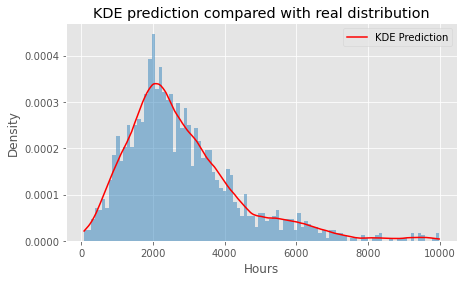

In [142]:
#Continous variable example
data = table_C[table_C["Hours"] < 10000]["Hours"].values

model_Hours = PDF_KDE(data, "Hours")

----------------------------------------
Best hyperparameters
----------------------------------------
{'bandwidth': 0.01, 'kernel': 'exponential'} : 510.6846533172725 None


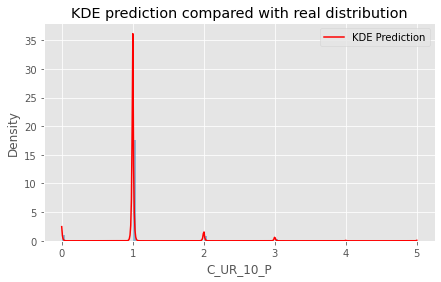

In [4]:
#Discrete variable example

data = table_C["C_UR_10_P"].values
model_C_UR_10_P = PDF_KDE(data, "C_UR_10_P")

In [15]:
prob_estimation(model_C_UR_10_P, 1)
prob_estimation(model_C_UR_10_P, 0.9) #Should be 0


Probability estimation for 1 is 44.15437003405204
Probability estimation for 0.9 is 0.002004605298252782


0.002004605298252782

In [9]:
np.array(1).reshape(-1,1)

array([[1]])

It does not work for discrete data since it estimates a continous PDF. In other words, KDE do not take into account that some values are impossible.

## 2.2. Scipy distributions estimation

### Functions:

In [51]:
# matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
# matplotlib.style.use('ggplot')

""" Model data by finding best fit distribution to data -------------------- """
def best_fit_distribution(data, bins=200):
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
#                 print(f"Distribution:{distribution},sse:{sse}")
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                    
#                     if best_sse < 0.2:
#                         return (best_distribution.name, best_params)

        except Exception:
            pass
    print("Squared error of the best distribution", sse)
    return (best_distribution.name, best_params)


""" Generate distributions's Probability Distribution Function -------------------- """ 
def make_pdf(dist, params, size=10000):
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)
    
    return pdf


""" Find and generate the most suitable PDF for the data provided --- #CALL THIS FUNCTION """ 
def find_gen_PDF(data, parameter, bins, plot = False):

    # Find best fit distribution
    print("Find best fit distribution")
    best_fit_name, best_fit_params = best_fit_distribution(data, bins)    
    best_dist = getattr(st, best_fit_name)

    # Make PDF with best params 
    print("Make PDF")
    pdf = make_pdf(best_dist, best_fit_params)
    
    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)
    print(f"{parameter} with best fit distribution\n {dist_str}")
    
    if plot == True:
        # Display best solution
        plt.figure(figsize=(12,8))
        ax = pdf.plot(lw=2, label='PDF', legend=True)
        data.plot(kind='hist', bins= bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

        ax.set_title(f"{parameter} with best fit distribution\n {dist_str}")
        ax.set_xlabel(f'{parameter}')
        ax.set_ylabel('Frequency')
    
    pdf = pdf.reset_index()
    pdf.rename(columns={'index': 'Distribution', 0 : "Probability"},  inplace = True)
    
    return pdf, best_dist, best_fit_params

Find best fit distribution
Squared error of the best distribution nan
Make PDF
Hours with best fit distribution
 fisk(c=3.80, loc=-524.29, scale=3010.06)


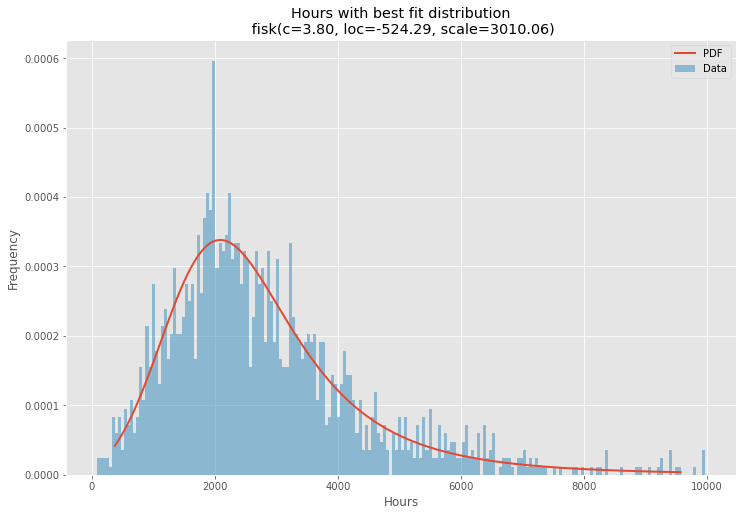

In [52]:
data = table_C[table_C["Hours"] < 10000]["Hours"]
pdf, best_dist, best_fit_params = find_gen_PDF(data, "Hours", plot = True, bins = 200)

Text(0, 0.5, 'Proabbility density')

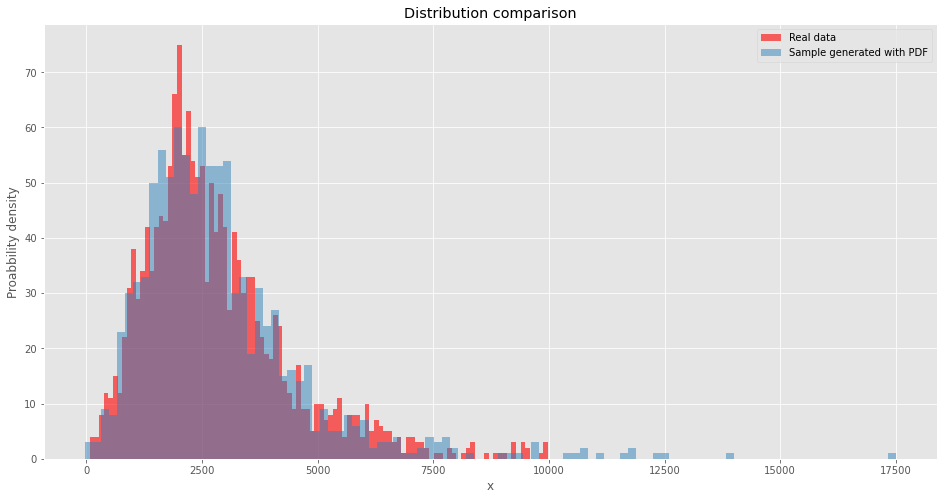

In [75]:
# Random sample
sample = best_dist.rvs(*best_fit_params, size=1000)

# Ploting sample
fig, ax = plt.subplots(figsize=(16,8))

# Data
ax.hist(x=data, density=False, bins=100, color="red", alpha=0.6, label = "Real data")

# Sample generated
ax.hist(x=sample, density=False, bins=100, color="#3182bd", alpha=0.5, label = "Sample generated with PDF")

ax.legend()
ax.set_title('Distribution comparison')
ax.set_xlabel('x')
ax.set_ylabel('Proabbility density')